# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import os
from neuralop.models import FNO
from torch.utils.data import DataLoader, Dataset
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
import numpy as np
from math import pi

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cuda


# Helper Functions

In [2]:
def load_data_from_paths(paths):
    all_tensors = []
    for p in paths:
        try:
            # Load the .pt file directly as a tensor
            tensor_data = torch.load(p).float()
            all_tensors.append(tensor_data)
        except Exception as e:
            print(f"Warning: Error loading {p}: {e}")
    # Concatenate all runs along the time dimension (dim=0)
    return torch.cat(all_tensors, dim=0)

In [3]:
def plot_model_performance(test_loader, model_imported, device, z_phys: float, t_phys: float):
    """
    Plots the true, predicted, and absolute error fields for velocity components (Vr, Vtheta, Vz)
    at a specified physical Z-slice and physical time.
    
    This function searches the test_loader for the time sample closest to t_phys
    and calculates the z-grid index closest to z_phys.

    Args:
        test_loader (torch.utils.data.DataLoader): DataLoader containing the test data.
        model_imported (torch.nn.Module): The trained PyTorch model.
        device (torch.device): The device (CPU or CUDA) the data/model resides on.
        z_phys (float): The physical Z-coordinate to visualize (valid range: [0, 0.5]).
        t_phys (float): The physical time (in seconds) to visualize (valid range: [0, 2.0]).
    """
    
    # --- Input Validation ---
    if not (0.0 <= t_phys <= 2.0):
        raise ValueError(f"Requested time t={t_phys:.4f}s is outside the valid range [0.0, 2.0].")
        
    if not (0.0 <= z_phys <= 0.5):
        raise ValueError(f"Requested z-coordinate z={z_phys:.4f}m is outside the valid range [0.0, 0.5].")
    # ---------------------------------
    
    # --- Data Preparation: Find the closest time sample ---
    best_x_sample = None
    best_y_sample = None
    min_time_diff = float('inf')
    actual_time_found = None

    print(f"Searching test data for sample closest to t={t_phys:.4f}s...")
    
    for batch in test_loader:
        x_batch = batch['x'].to(device)
        y_batch = batch['y'].to(device)
        
        # Infer time from the 4th channel
        times_in_batch = x_batch[:, 3, 0, 0, 0] # Shape [BatchSize]
        
        # Find the minimum time difference in this batch
        time_diffs = torch.abs(times_in_batch - t_phys)
        batch_min_diff, batch_min_idx = torch.min(time_diffs, dim=0)
        
        # Check if this batch's best is the overall best
        if batch_min_diff.item() < min_time_diff:
            min_time_diff = batch_min_diff.item()
            best_x_sample = x_batch[batch_min_idx].unsqueeze(0)
            best_y_sample = y_batch[batch_min_idx].unsqueeze(0)
            actual_time_found = times_in_batch[batch_min_idx].cpu().item()

    if best_x_sample is None:
        print("Error: Could not find any data in test_loader.")
        return

    print(f"Found sample. Requested t={t_phys:.4f}s, using closest t={actual_time_found:.4f}s.")
    
    x_sample = best_x_sample
    y_sample = best_y_sample

    # --- Model Inference ---
    model_imported.eval()
    with torch.no_grad():
        y_pred = model_imported(x_sample)

    # ----------------------------------------------------------------------
    # --- COORDINATE CALCULATION ---
    
    time_instant_sec = actual_time_found

    z_dim = y_sample.shape[4]
    z_coords_phys = np.linspace(0, 0.5, z_dim)
    z_index = np.argmin(np.abs(z_coords_phys - z_phys))
    z_value_phys_actual = z_coords_phys[z_index]

    if np.abs(z_value_phys_actual - z_phys) > (0.5 / (z_dim - 1)):
         print(f"Warning: Requested z={z_phys:.4f} is far from the closest grid point z={z_value_phys_actual:.4f}.")
         
    r_dim = y_sample.shape[2]
    theta_dim = y_sample.shape[3]

    r_coords = np.linspace(0, 1, r_dim)
    theta_coords = np.linspace(0, 2 * pi, theta_dim)

    # --- TENSOR SLICING and ERROR CALCULATION ---
    true_slice = y_sample[0, :, :, :, z_index].cpu() # shape [3, R_dim, Theta_dim]
    pred_slice = y_pred[0, :, :, :, z_index].cpu()   # shape [3, R_dim, Theta_dim]
    error_slice = torch.abs(true_slice - pred_slice) # shape [3, R_dim, Theta_dim]

    # --- DYNAMIC COLOR SCALE CALCULATION ---
    v_min_max_scales = []
    for i in range(3):
        combined_data = torch.cat((true_slice[i].flatten(), pred_slice[i].flatten()))
        vmin = combined_data.min().item()
        vmax = combined_data.max().item()
        v_min_max_scales.append((vmin, vmax))

    e_vmax = error_slice.max().item()
    e_vmin = 0.0
    # ----------------------------------------------------------------------

    # --- Plotting Setup ---
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    components = ['$V_r$', "$V_\\theta$", '$V_z$']

    r_ticks = np.linspace(0, r_dim - 1, num=5, dtype=int)
    r_labels = [f"{r_coords[i]:.2f}" for i in r_ticks]

    pi_coords = np.array([0, 0.5, 1.0, 1.5, 2.0])
    theta_ticks = (pi_coords * (theta_dim - 1) / 2.0).round().astype(int)
    theta_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]

    fig.suptitle(
        f"Model Performance Comparison (Time: {time_instant_sec:.4f} s)", 
        fontsize=16, 
        fontweight='bold'
    )
    fig.text(
        0.5, 0.93, 
        f"Velocity Slice at Axial Position $z$={z_value_phys_actual:.4f} m (Index {z_index})", 
        ha='center', 
        fontsize=12
    )

    # Plotting Loop
    for i in range(3):
        vmin, vmax = v_min_max_scales[i]
        
        im0 = axs[0, i].imshow(true_slice[i], cmap='cividis', origin='lower', vmin=vmin, vmax=vmax)
        axs[0, i].set_title(f"True {components[i]}")
        
        im1 = axs[1, i].imshow(pred_slice[i], cmap='cividis', origin='lower', vmin=vmin, vmax=vmax)
        axs[1, i].set_title(f"Predicted {components[i]}")
        
        im2 = axs[2, i].imshow(error_slice[i], cmap='magma', origin='lower', vmin=e_vmin, vmax=e_vmax)
        axs[2, i].set_title(f"Absolute Error in {components[i]}")

        plt.colorbar(im0, ax=axs[0:2, i], fraction=0.046, pad=0.04, label=f"Velocity Magnitude") 

        for row in range(3):
            axs[row, i].set_xticks(r_ticks)
            axs[row, i].set_xticklabels(r_labels)
            
            axs[row, i].set_yticks(theta_ticks)
            axs[row, i].set_yticklabels(theta_labels)
            
            if row == 2:
                axs[row, i].set_xlabel("R-coordinate (unitless)")
            if i == 0:
                 axs[row, i].set_ylabel(r"$\Theta$-coordinate (Radians)")

    plt.colorbar(im2, ax=axs[2, :], fraction=0.015, pad=0.04, label="Absolute Error")

    plt.show()

# Data Loading and Preprocessing

In [4]:
# Loading test paths to ensure the test files are the same as in the training script
with open('test_paths.txt', 'r') as f:
    test_paths = [line.strip() for line in f]

# --- Load Test Data ---
print("Loading test data...")
test_data_sequence = load_data_from_paths(test_paths)

Loading test data...


In [5]:
# Fit and Transform
# Split the data 
velocity_test_seq = test_data_sequence[:, 0:3, :, :, :]
force_test_seq = test_data_sequence[:, 3, 0, 0, 0]

# --- Create TWO normalizers ---
velocity_normalizer = UnitGaussianNormalizer(dim=[0, 2, 3, 4]) 
force_normalizer = UnitGaussianNormalizer(dim=[0]) 

print("Fitting the normalizers.")
velocity_normalizer.fit(velocity_test_seq)
force_normalizer.fit(force_test_seq)

print("Normalizing the data.")
velocity_test_seq = velocity_normalizer.transform(velocity_test_seq)
force_test_seq = force_normalizer.transform(force_test_seq)
print("Normalization complete.")

spatial_dims = velocity_test_seq.shape[2:]
force_test_seq = force_test_seq.view(-1, 1, 1, 1, 1).expand(-1, -1, *spatial_dims)

test_data = torch.cat([velocity_test_seq, force_test_seq], dim=1)

# --- FINAL SANITY CHECK ---
print(f"Normalized test data mean: {test_data.mean():.4f}") # Should be ~0.0
print(f"Normalized test data std: {test_data.std():.4f}")  # Should be ~1.0

print("Clearing RAM")
del test_data_sequence
del velocity_test_seq
del force_test_seq

Fitting the normalizers.
Normalizing the data.
Normalization complete.
Normalized test data mean: -0.0000
Normalized test data std: 1.0000
Clearing RAM


# Loading the Model

In [6]:
# --- Simple Dataset Class ---
class TimeSteppingDataset(Dataset):
    """
    A simple dataset that just returns the (t, t+1) pairs
    from a pre-normalized data sequence.
    
    This version is "run-aware" to prevent mixing
    data from different simulation runs.
    """
    def __init__(self, data_sequence, steps_per_run):
        """
        Args:
            data_sequence (torch.Tensor): The giant tensor of all runs
            steps_per_run (int): The number of time steps in EACH run
                                 (e.g., 100)
        """
        self.data = data_sequence
        self.steps_per_run = steps_per_run
        
        # We can't use the last step of any run as an input 'x'
        self.valid_pairs_per_run = self.steps_per_run - 1
        
        # Calculate how many runs are in this tensor
        self.num_runs = self.data.shape[0] // self.steps_per_run
        
        if self.data.shape[0] % self.steps_per_run != 0:
            print(f"Warning: Data shape {self.data.shape[0]} is not "
                  f"perfectly divisible by steps_per_run {self.steps_per_run}")

    def __len__(self):
        """
        Returns the total number of *valid* (t, t+1) pairs.
        """
        return self.num_runs * self.valid_pairs_per_run

    def __getitem__(self, idx):
        """
        Gets the N-th *valid* pair, skipping boundaries.
        'idx' will be from 0 to (total_valid_pairs - 1)
        """
        
        # Which run is this pair in?
        # e.g., if valid_pairs_per_run=99, idx=100 -> run_index=1
        run_index = idx // self.valid_pairs_per_run
        
        # What is the time-index within that run?
        # e.g., if valid_pairs_per_run=99, idx=100 -> time_index=1
        time_index_in_run = idx % self.valid_pairs_per_run
        
        # What is the actual index in the giant data tensor?
        # This calculation skips the boundary indices.
        # e.g., run_index=1, time_index=1 -> (1 * 100) + 1 = 101
        global_start_idx = (run_index * self.steps_per_run) + time_index_in_run
        
        x = self.data[global_start_idx]
        y = self.data[global_start_idx + 1]
        
        return {'x': x, 'y': y[:3], 'run_index': run_index, 'time_index': time_index_in_run}

In [7]:
# --- Create Datasets and DataLoaders ---

# Since each .pt file has 41 time steps:
STEPS_PER_RUN = 41 

# Create the datasets from normalized tensors
test_dataset = TimeSteppingDataset(test_data, steps_per_run=STEPS_PER_RUN)

# Create the DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
model_imported = FNO(
    n_modes=(10, 10, 10),
    hidden_channels=96,
    in_channels=4,
    out_channels=3,
    n_layers=3
).to(device)

checkpoint_path = './best_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model_imported.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Plotting

Plotting lateral acceleration for the first validation file.


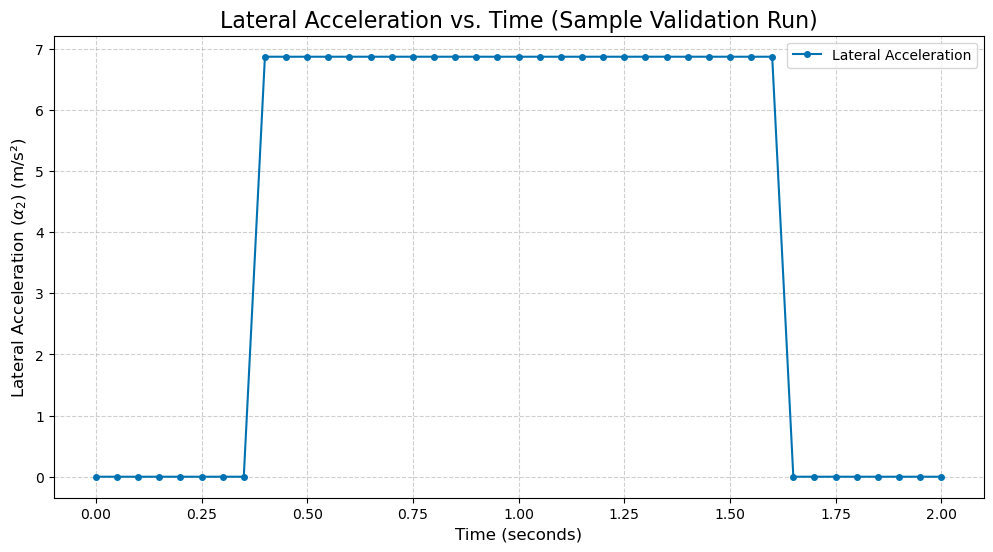

In [11]:
# --- Get the data for one simulation run ---
STEPS_PER_RUN = 41
one_run_normalized = test_data[0:STEPS_PER_RUN] # Shape [41, 6, 32, 32, 32]

# --- Extract the lateral acceleration (alpha2) ---
# It's in the 4th channel (index 3)
# It's constant across space, so we just sample from one point (0,0,0)
alpha2_normalized = one_run_normalized[:, 3, 0, 0, 0]

# --- Un-normalize the data ---
# We use the 'force_normalizer' that was fitted on the training data
# to get back the physical values.
# We need to .cpu().numpy() for plotting
alpha2_physical = force_normalizer.inverse_transform(alpha2_normalized).cpu().numpy()

# --- Create the time vector ---
# You stated each file has 41 timesteps
time_step_duration = 0.05
num_steps = len(alpha2_physical)
time_vector = np.arange(0, num_steps) * time_step_duration

# --- Plot the data ---
print(f"Plotting lateral acceleration for the first validation file.")

# Create the figure
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(time_vector, alpha2_physical, marker='o', linestyle='-', markersize=4, color='#0072B2', label='Lateral Acceleration')

# --- Add labels and title ---
plt.title("Lateral Acceleration vs. Time (Sample Validation Run)", fontsize=16)

# X-axis
plt.xlabel("Time (seconds)", fontsize=12)

# Y-axis
plt.ylabel("Lateral Acceleration ($\\alpha_2$) (m/s²)", fontsize=12)

# Add a grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(loc='best')

plt.show()

Searching test data for sample closest to t=1.5000s...
Found sample. Requested t=1.5000s, using closest t=1.5011s.


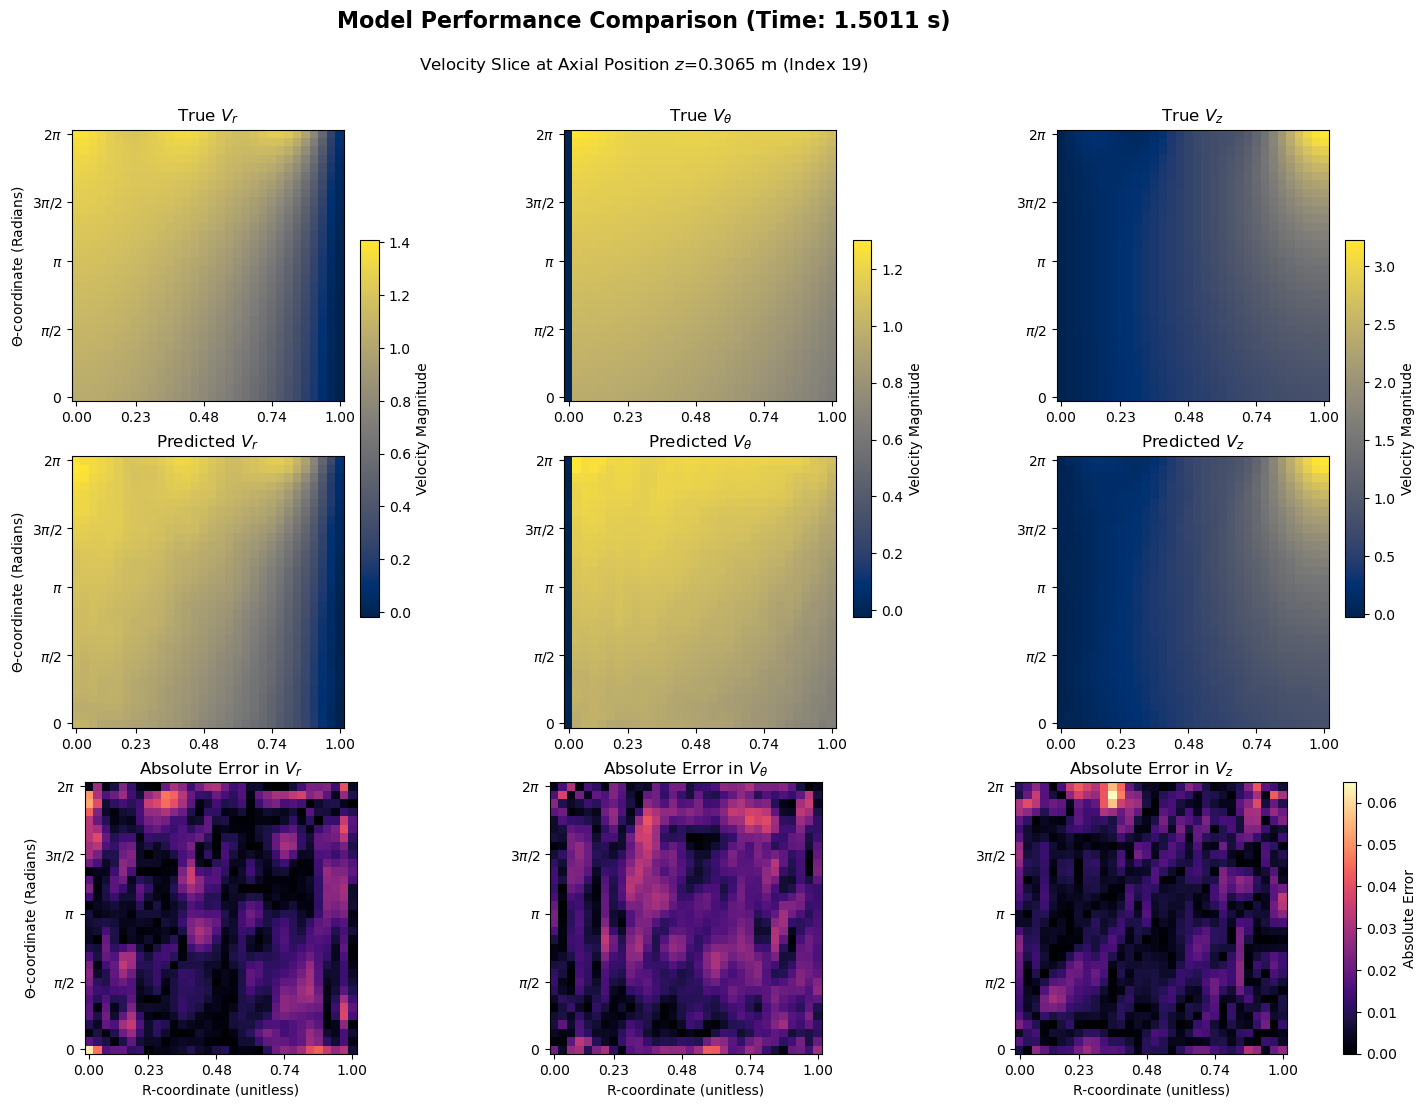

In [9]:
z_value = 0.3 # Must be a value between 0 and 0.5
t_value = 1.5 # Must be a value between 0 and 2.0

# ------------------------------------------------------------------------------
# --- EXAMPLE USAGE ---
# To use this function, define the z and t values in the above lines
plot_model_performance(test_loader, model_imported, device, z_phys=z_value, t_phys=t_value)
# ------------------------------------------------------------------------------